============ Datathon INSTRUCTIONS and INFORMATION ============

Challenge: SkyHigh Books want to know in 2018 what readers will rate their books that they publish. You are given data from 2017, where you know what readers read and what rating each user provided on average to all books they read.

Your job is 4 fold:

Predict what readers will rate on average in 2018 on all books they will read in 2017 + 2018. Use the wishlist of books readers want to read in 2018 and what they have already read in 2017 as a starting point. SkyHigh Books wants to know this information, as they want to market directly to readers who either have higher potential average scores on all books, or lower scores.

SkyHigh Books wants to know why some books in 2017 or 2018 (predict which books) have good or bad overall ratings. Is it certain words in the book? The genre of the book? The price in 2017 / 2018? Where it was sold? Why do some books on average have a higher rating than other books?

SkyHigh Books wants to maintain a good online presence on book review sites (hence we want to predict user averages), and so they want you to tell them how they can lift overall global reader satisifcation (not just each individual user, but overall).

Provide confidence bounds on your predictions. How much % are you sure your predictions are true or correct? Is the results plausible? Does the data seem plausible? (Ie do the word count follow some Power Law Distribution?)

**Datasets**

You are provided with 6 datasets:

1. **Books Information**
2. **Genres Mapping**
3. **User Data**
4. **Words in Book**
5. **Words Mapping**
6. **Example Submissions**

------

1. **Books Information** Actual info on books. Book ID, Barcode, difficulty (average *perceieved* reading difficulty of book --> 1 = easy, 5 = hard).
2. **Genres Mapping** Maps Genre IDs to real Genre types (eg Science)
3. **User Data** User's data on average ratings and what they read in 2017 + wishlist for 2018.
4. **Words in Book** What are the words in the actual book.
5. **Words Mapping** Actual words mapped to word ID
6. **Example Submissions** Shows an example of what you need to provide.

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn import datasets, metrics
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from surprise.model_selection import train_test_split, cross_validate
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt


In [3]:
## loading data
Books_Information = pd.read_csv('Books information.csv')
User_Data = pd.read_csv('User Data.csv').replace("Not specified", np.nan)



In [4]:
Books_Information.isnull().sum()

Book ID                          0
Book Genre                       0
Barcode                          0
Difficulty (Reader suggested)    0
Number Of Words                  0
Price (2017)                     0
Price (2018)                     0
Most Sold At                     0
Number Sold                      0
dtype: int64

In [5]:
user_2017 = User_Data.iloc[:, [0, 1, 2, 4]]
arr_2017 = [[columns[0], columns[1], int(book), float(columns[3])] for columns in user_2017.values for book in columns[2].split(', ')]
user_2017 = pd.DataFrame(arr_2017, columns=user_2017.columns)

user_2018 = User_Data.iloc[:, [0, 1, 3]]
arr_2018 = [[columns[0], columns[1], int(book)] for columns in user_2018.values for book in columns[2].split(', ')]
user_2018 = pd.DataFrame(arr_2018, columns=user_2018.columns)

In [6]:
df_2017 = user_2017.merge(Books_Information, left_on='User Read Books (2017)', right_on='Book ID')
df_2018 = user_2018.merge(Books_Information, left_on='User Read Books (2018)', right_on='Book ID')

df_2017 = df_2017[["User ID", "User Read Books (2017)", "User Difficulty Choice", "Book Genre", "Difficulty (Reader suggested)", "Number Of Words", "Price (2017)", "Most Sold At", "Number Sold", "Average Rating (2017)"]].rename(columns={'User Read Books (2017)': 'Book', 'Price (2017)': 'Price', 'Average Rating (2017)': "Rating"})
df_2018 = df_2018[["User ID", "User Read Books (2018)", "User Difficulty Choice", "Book Genre", "Difficulty (Reader suggested)", "Number Of Words", "Price (2018)", "Most Sold At", "Number Sold"]].rename(columns={'User Read Books (2018)': 'Book', 'Price (2018)': 'Price'})

In [7]:
X = df_2017.iloc[:, 2:8].values
y = df_2017.iloc[:, -1].values

In [8]:
# Taking care of missing data
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X[:, 0].reshape(-1, 1))
X[:, 0] = imputer.transform(X[:, 0].reshape(-1, 1)).round().reshape(-1, )

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelencoder = LabelEncoder()
X[:, 5] = labelencoder.fit_transform(X[:, 5])
onehotencoder = OneHotEncoder(categorical_features = [1, 5])
X = onehotencoder.fit_transform(X).toarray()

In [10]:
# feature scaling

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
sc_y = StandardScaler()
y = sc_y.fit_transform(y.reshape(-1, 1))

In [11]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor


In [13]:
ridge = Ridge(alpha=0.1)
# bagging 把很多小的分类器放在一起，每个train随机的一部分数据，然后把它们的最终结果综合起来（多数投票）
# bagging 算是一种算法框架


In [25]:
KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X_train)


>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([1, 2, 3, 4])
>>> kf = KFold(n_splits=2)
>>> kf.get_n_splits(X)
2
>>> print(kf)  
KFold(n_splits=2, random_state=None, shuffle=False)
>>> for train_index, test_index in kf.split(X):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]

5

In [43]:
def rmsle_cv(n_folds, model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y_train.ravel(), scoring="neg_mean_squared_error", cv=kf.get_n_splits(X_train)))
    print("rmse", rmse)
    return (rmse)


In [44]:
rmsle_cv(5, BaggingRegressor(base_estimator=ridge, n_estimators=param))

rmse [ 0.98205154  1.00733912  1.00323295  0.99307723  0.98853327]


array([ 0.98205154,  1.00733912,  1.00323295,  0.99307723,  0.98853327])

0.994761389409


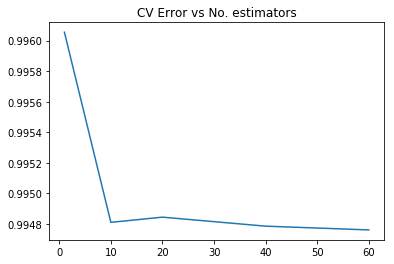

In [20]:
params = [1, 10, 20, 40, 60]
test_scores = []
for param in params:
    clf = BaggingRegressor(base_estimator=ridge, n_estimators=param)
    # cv=5表示cross_val_score采用的是k-fold cross validation的方法，重复5次交叉验证
    # scoring='precision'、scoring='recall'、scoring='f1', scoring='neg_mean_squared_error' 方差值
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train.ravel(), cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
print(test_score.mean())
plt.plot(params, test_scores)
plt.title('CV Error vs No. estimators')
plt.show()


In [ ]:
KFold(5, shuffle=True, random_state=42).get_n_splits(X_train)

In [ ]:
cross_val_score

In [ ]:
#Validation function
n_folds = 5


def rmsle_cv(model):
    kf = KFold(
        n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(
        model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    print("rmse", rmse)
    return (rmse)

In [ ]:
algo.fit(trainset)